# Import libraries

In [1]:
import time
from pathlib import Path
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np

# conditional random fields
import ace_sklearn_crfsuite
from ace_sklearn_crfsuite import metrics

# self-made
import src.analysis as analysis
import src.anomaly_model as anomaly_model
import src.utils as utils
import src.sensor_model as sensor_model

working_path = Path().resolve()
layout_database_path = working_path / "layout_data"

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

def fall_feature_sliding(mat, time_step, window_len, nrt_type = "instantaneous"):
    """
    Calculate features for fall detection.
    The feature includes;
    1: non response time of all sensors at the present time
    2: maximum height of the edge of the non response time sequence in the left / right part of the window.

    Parameters
    ----------
    mat : nummpy.ndarray of bool
        Raw sensor data matrix.
        mat[i][j] = j-th sensor state at i-th time.
    time_step : float
        Time step length [seconds] of mat = mat[1][0] - mat[0][0].
    window_len : int
        Length of window.
        window_len is the number of columns in mat.
        window_len must be an odd number.
    mode : int
        "instantaneous" : instantaneous non response time
        "sum" : sum in the window
        "max" : max in the window
    
    Returns
    -------
    feature : numpy.ndarray
        (number of time, dimension of feature).
        feature[t] = feature vector of the t-th time.
        feature.shape[0] == mat.shape[0].
        Let w be a (window_len - 1)/2.
        feature.shape[i] is a vector made from mat[i-w/2:i+w/2+1] for any w/2 <= i <mat.shape[0]-w/2
        feature.shape[i] is a vector made from mat[0:i+w/2+1] for any i < w/2.
        feature.shape[i] is a vector made from mat[i-w/2:mat.shape[0]] for any i >= mat.shape[0]-w/2.
        sensor_num_dic saves the realtion between index of sensors and index of features.
    """
    feature = np.zeros((mat.shape[0], mat.shape[1]), dtype = np.int32)
    for i, item in enumerate(gen_fall_feature_sliding(mat, time_step, window_len, nrt_type)):
        feature[i] = item
    return feature

def gen_fall_feature_sliding(mat, time_step, window_len, nrt_type = "instantaneous"):
    """
    Generator.
    Calculate features for fall detection.
    The feature includes;
    1: non response time of all sensors at the present time
    2: maximum height of the edge of the non response time sequence in the left / right part of the window.

    Parameters
    ----------
    mat : nummpy.ndarray of bool
        Raw sensor data matrix.
        mat[i][j] = j-th sensor state at i-th time.
    time_step : float
        Time step length [seconds] of mat = mat[1][0] - mat[0][0].
    window_len : int
        Length of window.
        window_len is the number of columns in mat.
        window_len must be an odd number.
    mode : int
        "instantaneous" : instantaneous non response time
        "sum" : sum in the window
        "max" : max in the window
    
    Yields
    ------
    feature : numpy.ndarray
        (dimension of feature, ).
    """

    def edge_detection(window_data):
        """
        Parameters
        ----------
        window_data : numpy.ndarray
            Non response time. The shape is (window_len, num. of sensors).

        Returns
        -------
        (left_edge_height, right_edge_height) : tuple of int
            left_edge_height is a maximum height of the edge in the left part of the window.
        """
        # Flatten the window by calculating max value among all sensors
        window_data = np.max(window_data, axis = 1)
        # convolution for edge detection
        _filter = np.array([-1, 1])
        edge = np.convolve(window_data, _filter, 'valid')
        half_window_len = int((len(window_data) - 1) / 2)
        left_edge_height = np.max(edge[:half_window_len])
        right_edge_height = np.max(edge[half_window_len:])
        return (left_edge_height, right_edge_height)
    
    def summarize_window(window_data):
        if nrt_type == "sum":
            return np.count_nonzero(window_data, axis=0)
        elif nrt_type == "max":
            return np.max(window_data, axis = 0)
        elif nrt_type == "instantaneous":
            center = int((window_data.shape[0] - 1) / 2)
            return window_data[center]

    # Initialize the output array
    sensor_num = mat.shape[1]
    last_fired_time = np.full((sensor_num,), -1)
    last_fired_sensors = np.zeros(sensor_num, dtype = bool)
    
    w = int((window_len - 1)/2)
    window_data = np.zeros((window_len, sensor_num))

    for i in range(w):
        sd = mat[i]
        if np.any(sd):
            for s in range(sensor_num):
                if not last_fired_sensors[s] and sd[s]:
                    last_fired_time[s] = i
                if last_fired_sensors[s] and not sd[s]:
                    last_fired_time[s] = -1
            last_fired_sensors = sd

        instantaneous_nrt = np.empty(sensor_num)
        for s in range(sensor_num):
            instantaneous_nrt[s] = ((i - last_fired_time[s] + 1) if last_fired_time[s] != -1 else 0)
        window_data[i+w+1, :] = instantaneous_nrt

    # [0, 0, 0, a, b] for example of w = 2.

    for i in range(w, mat.shape[0]):
        utils.print_progress_bar(mat.shape[0] - 1, i, "Extract fall features.", step = 1000)
        # center = i - w  # index of window center
        sd = mat[i]
        if np.any(sd):
            for s in range(sensor_num):
                if not last_fired_sensors[s] and sd[s]:
                    last_fired_time[s] = i
                if last_fired_sensors[s] and not sd[s]:
                    last_fired_time[s] = -1
            last_fired_sensors = sd

        instantaneous_nrt = np.empty(sensor_num)
        for s in range(sensor_num):
            instantaneous_nrt[s] = ((i - last_fired_time[s] + 1) if last_fired_time[s] != -1 else 0)

        # shift window
        # For example of w = 2;
        # from [a, b, c, d, e] to [b, c, d, e, f]
        window_data = np.roll(window_data, shift=-1, axis=0)
        window_data[-1, :] = instantaneous_nrt

        # Calculate elapsed time of the sliding window
        yield summarize_window(window_data) * time_step

    for center in range(mat.shape[0]-w, mat.shape[0]):
         # shift window
        window_data = np.roll(window_data, shift=-1, axis=0)
        window_data[-1, :] = np.zeros(sensor_num)

        # Calculate elapsed time of the sliding window
        yield summarize_window(window_data) * time_step

def extract_data_with_fall_feature_sliding(path, data_type = "raw", time_step = 1, window_len = 121, nrt_type = "instantaneous", data_range = "full", half_len = 10000):
    if data_range not in ["full", "around_anomalies"]:
        raise ValueError("data_range is invalid value!")
    
    SD_model = utils.pickle_load(path, "SD_model")
    # SD = utils.pickle_load(path / "experiment", f"reduced_301_SD_mat_{data_type}_1")
    SD = utils.pickle_load(path / "experiment", f"SD_mat_raw_1")    # !!!!!!!!!!!!!!!!!!!!
    AL = utils.pickle_load(path / "experiment", f"AL_mat_raw_1")
    SD_names = utils.pickle_load(path / "experiment", "SD_names")

    # extract motion sensor data
    motion_sensor_indexes = []
    for i, s_i in enumerate(SD_names):
        if (SD_model[s_i].type_name in ['PIR', 'pressure', 'door']) and (i != 6):  # !!!!!!!!!!!!!!!!!
            motion_sensor_indexes.append(i)
    SD = SD[:, motion_sensor_indexes]

    # extract fall labels
    anomaly_index = 4
    AL = AL[:, anomaly_index]
    
    # extract features of non response time
    if data_range == "full":
        X = fall_feature_sliding(SD, time_step=time_step, window_len=window_len, nrt_type=nrt_type)
        return X, AL, motion_sensor_indexes
    elif data_range == "around_anomalies":
        fall_indices = analysis.find_true_regions_in_ndarray(AL)
        X = np.empty((0, len(motion_sensor_indexes)))
        y = []
        for r in fall_indices:
            start, end = r[0] - half_len, r[1] + half_len
            if (start < 0) or (SD.shape[0] < end):
                continue
            feature = fall_feature_sliding(SD[start:end], time_step=time_step, window_len=window_len, nrt_type=nrt_type)
            X = np.vstack((X, feature))
            for i in range(start, end):
                y.append(True in [r[0] <= i < r[1] for r in fall_indices])
        return X, np.array(y), motion_sensor_indexes
    
    
def online_detection_test(classifier, path, data_type = "raw", time_step = 1, window_len = 121, nrt_type = "instantaneous", data_range = "full", half_len = 10000,
                          buffer_size = 3600):
    """
    
    Returns
    -------
    (y_true, y_pred) : tuple of numpy.ndarray
    """

    def predict_with_buffer(classifier, SD, time_step, window_len, nrt_type, buffer_size=buffer_size):
        y_pred = np.zeros(SD.shape[0], dtype=bool)
        item_buffer = []
        buffer_indices = []

        for i, item in enumerate(gen_fall_feature_sliding(SD, time_step, window_len, nrt_type)):
            item_buffer.append(item.reshape(1, -1))
            buffer_indices.append(i)

            if len(item_buffer) >= buffer_size:
                buffer_array = np.vstack(item_buffer)
                y_pred_batch = classifier.predict(buffer_array)
                
                for index, pred in zip(buffer_indices, y_pred_batch):
                    y_pred[index] = pred
                
                item_buffer = []
                buffer_indices = []

        if item_buffer:
            buffer_array = np.vstack(item_buffer)
            y_pred_batch = classifier.predict(buffer_array)
            for index, pred in zip(buffer_indices, y_pred_batch):
                y_pred[index] = pred

        return y_pred
    
    
    if (data_range not in ["full", "around_anomalies"]) and not isinstance(data_range, tuple):
        raise ValueError("data_range is invalid value!")
    
    SD_model = utils.pickle_load(path, "SD_model")
    # SD = utils.pickle_load(path / "experiment", f"reduced_301_SD_mat_{data_type}_{time_step}")
    SD = utils.pickle_load(path / "experiment", f"SD_mat_{data_type}_{time_step}")
    AL = utils.pickle_load(path / "experiment", f"AL_mat_{data_type}_{time_step}")
    SD_names = utils.pickle_load(path / "experiment", "SD_names")

    # extract motion sensor data
    motion_sensor_indexes = []
    for i, s_i in enumerate(SD_names):
        if (SD_model[s_i].type_name in ['PIR', 'pressure', 'door']) and (i != 6):
            motion_sensor_indexes.append(i)
    SD = SD[:, motion_sensor_indexes]

    # extract fall labels
    anomaly_index = 4
    AL = AL[:, anomaly_index]

    # extract features of non response time
    if data_range == "full":
        return AL, predict_with_buffer(classifier, SD, time_step, window_len, nrt_type, buffer_size=3600)
    elif data_range == "around_anomalies":
        fall_indices = analysis.find_true_regions_in_ndarray(AL)
        y_true = []
        y_pred = []
        for r in fall_indices:
            start, end = r[0] - half_len, r[1] + half_len
            if (start < 0) or (SD.shape[0] < end):
                continue
            for i, item in enumerate(gen_fall_feature_sliding(SD[start:end], time_step, window_len, nrt_type)):
                y_pred.append(classifier.predict(item.reshape(1, -1)))
            for i in range(start, end):
                y_true.append(True in [r[0] <= i < r[1] for r in fall_indices])
        return y_true, y_pred
    elif isinstance(data_range, tuple):
        start, end = data_range[0], data_range[1]
        y_pred = np.zeros(end-start, dtype = bool)
        for i, item in enumerate(gen_fall_feature_sliding(SD[start:end], time_step, window_len, nrt_type)):
            y_pred[i] = classifier.predict(item.reshape(1, -1))
        return AL[start:end], y_pred


def online_detection_rule(path, data_type = "raw", time_step = 1, window_len = 121, nrt_type = "instantaneous", data_range = "full", half_len = 10000, second_threshold = 20):
    """
    
    Returns
    -------
    (y_true, y_pred) : tuple of numpy.ndarray
    """


    def classifier_rule(vec, valid_range):
        for i, v in enumerate(vec):
            if (i in valid_range) and v >= second_threshold:
                return True
        return False    
    
    if (data_range not in ["full", "around_anomalies"]) and not isinstance(data_range, tuple):
        raise ValueError("data_range is invalid value!")
    
    SD_model = utils.pickle_load(path, "SD_model")
    # SD = utils.pickle_load(path / "experiment", f"reduced_301_SD_mat_{data_type}_{time_step}")
    SD = utils.pickle_load(path / "experiment", f"SD_mat_{data_type}_{time_step}")
    AL = utils.pickle_load(path / "experiment", f"AL_mat_{data_type}_{time_step}")
    SD_names = utils.pickle_load(path / "experiment", "SD_names")

    # extract motion sensor data
    motion_sensor_indexes = []
    for i, s_i in enumerate(SD_names):
        if (SD_model[s_i].type_name in ['PIR', 'pressure', 'door']) and (i != 6):
            motion_sensor_indexes.append(i)
    SD = SD[:, motion_sensor_indexes]

    # extract fall labels
    anomaly_index = 4
    AL = AL[:, anomaly_index]

    valid_range = set(range(0, 22)) | {33, 34} 

    # extract features of non response time
    if data_range == "full":
        y_pred = np.zeros(SD.shape[0], dtype = bool)
        for i, item in enumerate(gen_fall_feature_sliding(SD, time_step, window_len, nrt_type)):
            y_pred[i] = classifier_rule(item, valid_range)
        return AL, y_pred
    elif data_range == "around_anomalies":
        fall_indices = analysis.find_true_regions_in_ndarray(AL)
        y_true = []
        y_pred = []
        for r in fall_indices:
            start, end = r[0] - half_len, r[1] + half_len
            if (start < 0) or (SD.shape[0] < end):
                continue
            for i, item in enumerate(gen_fall_feature_sliding(SD[start:end], time_step, window_len, nrt_type)):
                y_pred.append(classifier_rule(item, valid_range))
            for i in range(start, end):
                y_true.append(True in [r[0] <= i < r[1] for r in fall_indices])
        return y_true, y_pred
    elif isinstance(data_range, tuple):
        start, end = data_range[0], data_range[1]
        y_pred = np.zeros(end-start, dtype = bool)
        for i, item in enumerate(gen_fall_feature_sliding(SD[start:end], time_step, window_len, nrt_type)):
            y_pred[i] = classifier_rule(item, valid_range)
        return AL[start:end], y_pred

data_type = "raw"
time_step = 1
window_len = 121
# half_len = 5000
half_len = 30000
nrt_type = "instantaneous"

# training data

train_path = layout_database_path / "test_layout" / "fall_test_2"
X_train, y_train, motion_sensor_indexes  = extract_data_with_fall_feature_sliding(train_path, 
        data_type = data_type, time_step = time_step, window_len = window_len, nrt_type = nrt_type, data_range = "full", half_len = half_len)
print("Training data is ready!")

# decision tree
decision_tree = DecisionTreeClassifier(min_samples_leaf=5)
decision_tree.fit(X_train, y_train)
print("Classifier is ready!")

In [4]:
test_path = layout_database_path / "test_layout" / "test_data_5"

second_threshold = 5
y_test_rule, y_pred_rule = online_detection_rule(test_path,
        data_type = data_type, time_step = time_step, window_len=window_len, nrt_type = nrt_type, data_range = "around_anomalies", half_len = half_len,second_threshold=second_threshold)
print("Test error ------------------------")
print("Confusion matrix:")
print(confusion_matrix(y_test_rule, y_pred_rule))
print("Classification report")
print(classification_report(y_test_rule, y_pred_rule))
utils.pickle_dump(test_path / "experiment", "y_test_rule", y_test_rule)
utils.pickle_dump(test_path / "experiment", "y_pred_rule", y_pred_rule)

Extract fall features. 60038 / 60038. Completed!
Extract fall features. 60035 / 60035. Completed!
Extract fall features. 60023 / 60023. Completed!
Extract fall features. 60026 / 60026. Completed!
Extract fall features. 60034 / 60034. Completed!
Extract fall features. 60032 / 60032. Completed!
Extract fall features. 60030 / 60030. Completed!
Extract fall features. 60036 / 60036. Completed!
Extract fall features. 60034 / 60034. Completed!
Extract fall features. 60027 / 60027. Completed!
Extract fall features. 60037 / 60037. Completed!
Extract fall features. 60039 / 60039. Completed!
Extract fall features. 60034 / 60034. Completed!
Extract fall features. 60035 / 60035. Completed!
Extract fall features. 60034 / 60034. Completed!
Extract fall features. 60029 / 60029. Completed!
Extract fall features. 60018 / 60018. Completed!
Extract fall features. 60028 / 60028. Completed!
Extract fall features. 60038 / 60038. Completed!
Extract fall features. 60021 / 60021. Completed!
Extract fall feature

In [11]:
# test data
test_path = layout_database_path / "test_layout" / "test_data_5"

y_test_dt, y_pred_dt = online_detection_test(decision_tree, test_path,
        data_type = data_type, time_step=time_step, window_len=window_len, nrt_type = nrt_type, data_range = "around_anomalies", half_len = half_len)
print("Test error ------------------------")
print("Confusion matrix:")
print(confusion_matrix(y_test_dt, y_pred_dt))
print("Classification report")
print(classification_report(y_test_dt, y_pred_dt))
utils.pickle_dump(test_path / "experiment", "y_test_dt", y_test_dt)
utils.pickle_dump(test_path / "experiment", "y_pred_dt", y_pred_dt)

Extract fall features. 60038 / 60038. Completed!
Extract fall features. 60035 / 60035. Completed!
Extract fall features. 60023 / 60023. Completed!
Extract fall features. 60026 / 60026. Completed!
Extract fall features. 60034 / 60034. Completed!
Extract fall features. 60032 / 60032. Completed!
Extract fall features. 60030 / 60030. Completed!
Extract fall features. 60036 / 60036. Completed!
Extract fall features. 60034 / 60034. Completed!
Extract fall features. 60027 / 60027. Completed!
Extract fall features. 60037 / 60037. Completed!
Extract fall features. 60039 / 60039. Completed!
Extract fall features. 60034 / 60034. Completed!
Extract fall features. 60035 / 60035. Completed!
Extract fall features. 60034 / 60034. Completed!
Extract fall features. 60029 / 60029. Completed!
Extract fall features. 60018 / 60018. Completed!
Extract fall features. 60028 / 60028. Completed!
Extract fall features. 60038 / 60038. Completed!
Extract fall features. 60021 / 60021. Completed!
Extract fall feature

[Text(0.4732142857142857, 0.9, 'x[18] <= 3.5\ngini = 0.005\nsamples = 2592000\nvalue = [2585862, 6138]'),
 Text(0.23214285714285715, 0.7, 'x[8] <= 3.5\ngini = 0.004\nsamples = 2590936\nvalue = [2585813, 5123]'),
 Text(0.14285714285714285, 0.5, 'x[4] <= 3.5\ngini = 0.003\nsamples = 2590057\nvalue = [2585796, 4261]'),
 Text(0.07142857142857142, 0.3, 'x[9] <= 3.5\ngini = 0.003\nsamples = 2589184\nvalue = [2585695, 3489]'),
 Text(0.03571428571428571, 0.1, '\n  (...)  \n'),
 Text(0.10714285714285714, 0.1, '\n  (...)  \n'),
 Text(0.21428571428571427, 0.3, 'x[25] <= 1.5\ngini = 0.205\nsamples = 873\nvalue = [101, 772]'),
 Text(0.17857142857142858, 0.1, '\n  (...)  \n'),
 Text(0.25, 0.1, '\n  (...)  \n'),
 Text(0.32142857142857145, 0.5, 'x[8] <= 26.5\ngini = 0.038\nsamples = 879\nvalue = [17, 862]'),
 Text(0.2857142857142857, 0.3, 'gini = 0.0\nsamples = 707\nvalue = [0, 707]'),
 Text(0.35714285714285715, 0.3, 'x[5] <= 13.5\ngini = 0.178\nsamples = 172\nvalue = [17, 155]'),
 Text(0.321428571428

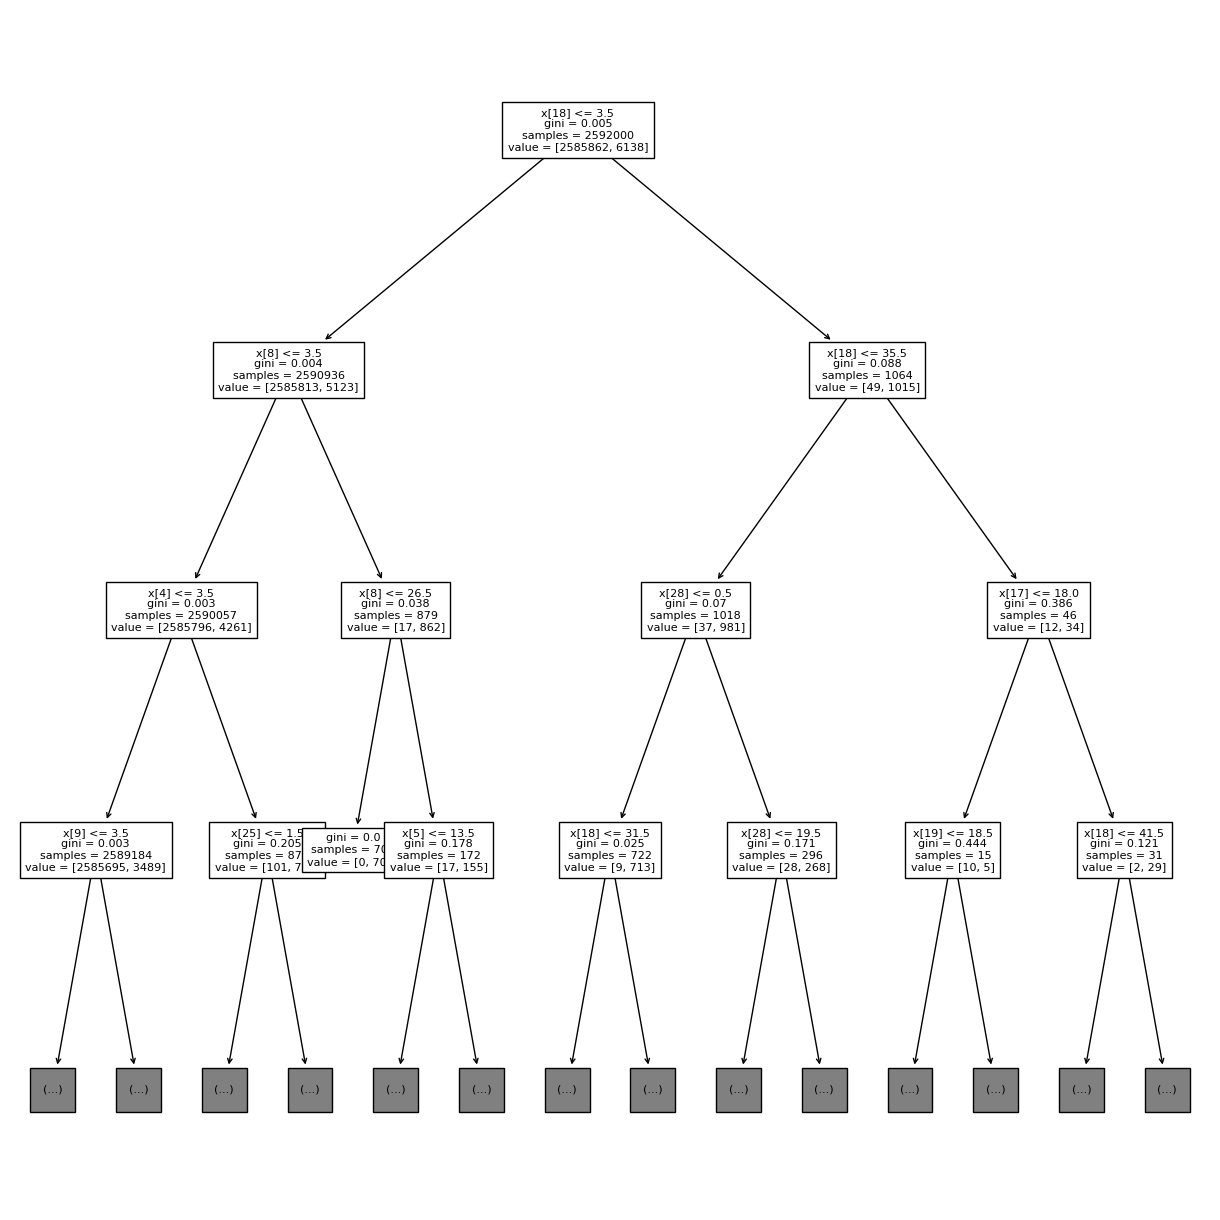

In [14]:
from sklearn import tree
fig, ax = plt.subplots(figsize=(12, 12), tight_layout=dict(pad=0))
tree.plot_tree(decision_tree, ax=ax, max_depth=3, fontsize=8)
# plt.savefig(train_path / "experiment" / 'decision_tree_graph', dpi=200)

In [5]:
end = 9*360*24*60*60
start = end - 3*30*24*60*60
test_path = layout_database_path / "test_layout" / "test_data_5"
second_threshold = 5
y_test_rule_long, y_pred_rule_long = online_detection_rule(test_path,
        data_type = data_type, time_step=time_step, window_len=window_len, nrt_type = nrt_type, 
        data_range = (start, end), half_len = half_len, second_threshold=second_threshold)

# y_pred = decision_tree.predict(X_train)
# print("Training error ------------------------")
# print("Confusion matrix:")
# print(confusion_matrix(y_train, y_pred))
# print("Classification report")
# print(classification_report(y_train, y_pred))

print("Test error Rule------------------------")
print("Confusion matrix:")
print(confusion_matrix(y_test_rule_long, y_pred_rule_long))
print("Classification report")
print(classification_report(y_test_rule_long, y_pred_rule_long))

Extract fall features. 7775999 / 7775999. Completed!
Test error Rule------------------------
Confusion matrix:
[[7773732    2240]
 [      2      26]]
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   7775972
        True       0.01      0.93      0.02        28

    accuracy                           1.00   7776000
   macro avg       0.51      0.96      0.51   7776000
weighted avg       1.00      1.00      1.00   7776000



In [4]:
end = 9*360*24*60*60
start = end - 3*30*24*60*60
test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_dt_long, y_pred_dt_long = online_detection_test(decision_tree, test_path,
        data_type = data_type, time_step=time_step, window_len=window_len, nrt_type = nrt_type, data_range = (start, end), half_len = half_len)

print("Test error DT------------------------")
print("Confusion matrix:")
print(confusion_matrix(y_test_dt_long, y_pred_dt_long))
print("Classification report")
print(classification_report(y_test_dt_long, y_pred_dt_long))

Extract fall features. 7775999 / 7775999. Completed!
Test error DT------------------------
Confusion matrix:
[[7774701    1271]
 [      1      27]]
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   7775972
        True       0.02      0.96      0.04        28

    accuracy                           1.00   7776000
   macro avg       0.51      0.98      0.52   7776000
weighted avg       1.00      1.00      1.00   7776000



In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
test_path = layout_database_path / "test_layout" / "test_data_5"
decision_tree = utils.pickle_load(test_path / "experiment", "decision_tree")

In [3]:
test_path = layout_database_path / "test_layout" / "test_data_5"
end = 9*360*24*60*60
start = end - 3*30*24*60*60
y_test_rule_long, y_pred_rule_long = online_detection_rule(test_path,
        data_type = data_type, time_step=time_step, window_len=window_len, nrt_type = nrt_type, data_range = "full", half_len = half_len)

print("Test error Rule------------------------")
print("Confusion matrix:")
print(confusion_matrix(y_test_rule_long, y_pred_rule_long))
print("Classification report")
print(classification_report(y_test_rule_long, y_pred_rule_long))
utils.pickle_dump(test_path / "experiment", "y_test_rule_long", y_test_rule_long)
utils.pickle_dump(test_path / "experiment", "y_pred_rule_long", y_pred_rule_long)

Extract fall features. 279935999 / 279935999. Completed!
Test error Rule------------------------
Confusion matrix:
[[279895984     39166]
 [      482       368]]
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00 279935150
        True       0.01      0.43      0.02       850

    accuracy                           1.00 279936000
   macro avg       0.50      0.72      0.51 279936000
weighted avg       1.00      1.00      1.00 279936000



In [10]:
test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_dt_long, y_pred_dt_long = online_detection_test(decision_tree, test_path,
        data_type = data_type, time_step=time_step, window_len=window_len, nrt_type = nrt_type, data_range = "full", half_len = half_len,
        buffer_size=3600)

print("Test error Rule------------------------")
print("Confusion matrix:")
print(confusion_matrix(y_test_dt_long, y_pred_dt_long))
print("Classification report")
print(classification_report(y_test_dt_long, y_pred_dt_long))
utils.pickle_dump(test_path / "experiment", "y_test_dt_long", y_test_dt_long)
utils.pickle_dump(test_path / "experiment", "y_pred_dt_long", y_pred_dt_long)

KeyboardInterrupt: 

In [20]:
test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_rule_long = utils.pickle_load(test_path / "experiment", "y_test_rule_long")
y_pred_rule_long = utils.pickle_load(test_path / "experiment", "y_pred_rule_long")
y_test_dt_long = utils.pickle_load(test_path / "experiment", "y_test_dt_long")
y_pred_dt_long = utils.pickle_load(test_path / "experiment", "y_pred_dt_long")
y_test_dt = utils.pickle_load(test_path / "experiment", "y_test_dt")
y_pred_dt = utils.pickle_load(test_path / "experiment", "y_pred_dt")


print("Test error Rule------------------------")
print("Confusion matrix:")
print(confusion_matrix(y_test_rule_long, y_pred_rule_long))

print("Test error DT------------------------")
print("Confusion matrix:")
print(confusion_matrix(y_test_dt_long, y_pred_dt_long))

len(consecutive_length): 11980
less than 5 [sec.]: 1039


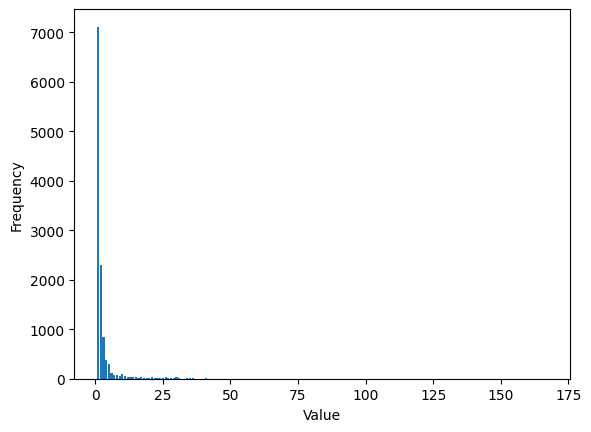

In [17]:
import matplotlib.pyplot as plt

true_regions = analysis.find_true_regions_in_ndarray(y_pred_dt_long)
consecutive_length = [r[1] - r[0] for r in true_regions]
print(f"len(consecutive_length): {len(consecutive_length)}")
seconds = 5
less_than_num = 0
for x in consecutive_length:
    if x > seconds:
        less_than_num += 1
print(f"less than {seconds} [sec.]: {less_than_num}")

sorted_one = sorted(consecutive_length)[:-30]
plt.hist(sorted_one, bins=range(min(sorted_one), max(sorted_one) + 2), align='left', rwidth=0.8)

# X軸に表示する値の設定
# plt.xticks(range(min(new), max(new) + 1))

# タイトルと軸ラベルの追加
plt.xlabel('Value')
plt.ylabel('Frequency')

# ヒストグラムの表示
plt.show()

In [6]:
print(sorted_one[-10:])

[527, 655, 802, 852, 973, 978, 1021, 1094, 1576, 2833]


In [20]:
interval = 5

compressed_y_test = np.array([all(y_test_rule_long[i:i+interval]) for i in range(0, len(y_test_rule_long), interval)])
compressed_y_pred = np.array([all(y_pred_rule_long[i:i+interval]) for i in range(0, len(y_pred_rule_long), interval)])

print("Test error ------------------------")
print("Confusion matrix:")
print(confusion_matrix(compressed_y_test, compressed_y_pred))
print("Classification report")
print(classification_report(compressed_y_test, compressed_y_pred))


compressed_y_test = np.array([all(y_test_dt_long[i:i+interval]) for i in range(0, len(y_test_dt_long), interval)])
compressed_y_pred = np.array([all(y_pred_dt_long[i:i+interval]) for i in range(0, len(y_pred_dt_long), interval)])

print("Test error ------------------------")
print("Confusion matrix:")
print(confusion_matrix(compressed_y_test, compressed_y_pred))
print("Classification report")
print(classification_report(compressed_y_test, compressed_y_pred))

Test error ------------------------
Confusion matrix:
[[1555039     156]
 [      4       1]]
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   1555195
        True       0.01      0.20      0.01         5

    accuracy                           1.00   1555200
   macro avg       0.50      0.60      0.51   1555200
weighted avg       1.00      1.00      1.00   1555200



In [2]:
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_dt_long = utils.pickle_load(test_path / "experiment", "y_test_dt_long")
y_pred_dt_long = utils.pickle_load(test_path / "experiment", "y_pred_dt_long")
y_test_dt = utils.pickle_load(test_path / "experiment", "y_test_dt")
y_pred_dt = utils.pickle_load(test_path / "experiment", "y_pred_dt")

_max = 35
days = 9 * 12  * 30
x = list(range(1, _max))
recall_list = []
far_list = []
hpfa_list = []
for interval in range(1, _max):
    utils.print_progress_bar(_max - 1, interval, "", 1)
    recall = recall_score(np.array([all(y_test_dt[i:i+interval]) for i in range(0, len(y_test_dt), interval)]),
                          np.array([all(y_pred_dt[i:i+interval]) for i in range(0, len(y_pred_dt), interval)]))
    recall_list.append(recall)
    temp_test = np.array([all(y_test_dt_long[i:i+interval]) for i in range(0, len(y_test_dt_long), interval)])
    temp_pred = np.array([all(y_pred_dt_long[i:i+interval]) for i in range(0, len(y_pred_dt_long), interval)])
    false_alarm_rate = np.sum((temp_test == False) & (temp_pred == True)) / days
    far_list.append(false_alarm_rate)
    hour_per_false_alarm = 24 / false_alarm_rate
    hpfa_list.append(hour_per_false_alarm)

 34 / 34. Completed!


In [8]:
threshold = 20
print(recall_list[threshold - 1])
print(far_list[threshold - 1])
print(hpfa_list[threshold - 1])

0.7647058823529411
0.3132716049382716
76.61083743842364


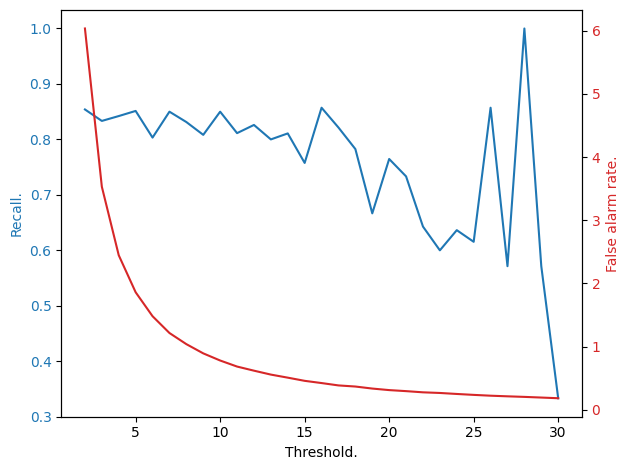

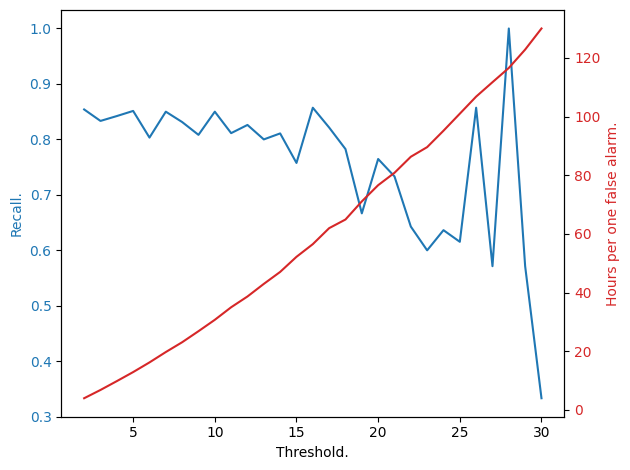

In [4]:
start_threshold = 1
end_threshold = 30
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Threshold.')
ax1.set_ylabel('Recall.', color=color)
ax1.plot(x[start_threshold:end_threshold], recall_list[start_threshold:end_threshold], color=color, label='Recall')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('False alarm rate.', color=color)
ax2.plot(x[start_threshold:end_threshold], far_list[start_threshold:end_threshold], color=color, label='False alarm rate.')
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()
plt.close()


start_threshold = 1
end_threshold = 30
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Threshold.')
ax1.set_ylabel('Recall.', color=color)
ax1.plot(x[start_threshold:end_threshold], recall_list[start_threshold:end_threshold], color=color, label='Recall')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Hours per one false alarm.', color=color)
ax2.plot(x[start_threshold:end_threshold], hpfa_list[start_threshold:end_threshold], color=color, label='Hours per one false alarm.')
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()
plt.close()

Number of walkings: 172996
Number of falling while walking: 26
Days of falling while walking: {128, 135, 1545, 910, 2067, 1687, 2338, 2860, 2481, 434, 1722, 2876, 3141, 2759, 464, 1490, 1107, 1495, 2139, 990, 2910, 3046, 2922, 2802, 3193, 2301}


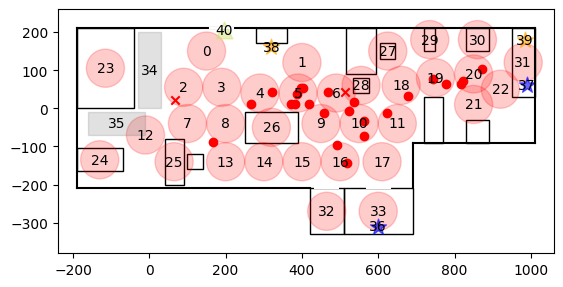

In [15]:
test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_dt = utils.pickle_load(test_path / "experiment", "y_test_dt")
y_pred_dt = utils.pickle_load(test_path / "experiment", "y_pred_dt")

# Plot fall places
layout_path = layout_database_path / "test_layout"
WT = utils.pickle_load(test_path, "WT")
sensors = utils.pickle_load(test_path, "SD_model")
true_regions = analysis.find_true_regions_in_ndarray(y_test_dt)
fall_w_points = []
fall_w_days = set()
fall_detection_rate = []
fall_num = 0
for i, wt in enumerate(WT):
    if wt.fall_w:
        fall_w_points.append(wt.centers[wt.fall_w_index])
        fall_w_days.add(wt.timestamp[0].days)
        r = true_regions[fall_num]
        fall_detection_rate.append(np.sum(y_pred_dt[r[0]:r[1]]) / (r[1]-r[0]))
        fall_num += 1
print(f"Number of walkings: {len(WT)}")
print(f"Number of falling while walking: {len(fall_w_points)}")
print(f"Days of falling while walking: {fall_w_days}")
success_points = []
miss_points = []
for p, r in zip(fall_w_points, fall_detection_rate):
    if r >= 0.7:
        success_points.append(p)
    else:
        miss_points.append(p)
ax = utils.save_layout(test_path, layout_path, sensors=sensors,WT=[],
    show=False, color_map_name="Blues", filename="fall_points",dpi=400,return_ax=True, with_name_furniture_place=False)
ax.scatter([p[0] for p in success_points], [p[1] for p in success_points], marker="o", color="red")
ax.scatter([p[0] for p in miss_points], [p[1] for p in miss_points], marker="x", color="red")
# plt.savefig(test_path / "experiment" / "fall_DT_3", dpi = 400, bbox_inches="tight")
plt.show()

Number of walkings: 172996
Number of falling while walking: 26
Days of falling while walking: {128, 135, 1545, 910, 2067, 1687, 2338, 2860, 2481, 434, 1722, 2876, 3141, 2759, 464, 1490, 1107, 1495, 2139, 990, 2910, 3046, 2922, 2802, 3193, 2301}


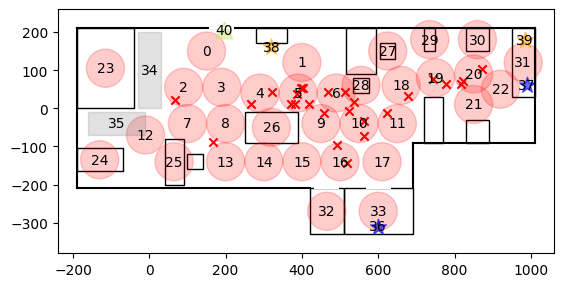

In [14]:
test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_rule = utils.pickle_load(test_path / "experiment", "y_test_rule")
y_pred_rule = utils.pickle_load(test_path / "experiment", "y_pred_rule")

# Plot fall places
layout_path = layout_database_path / "test_layout"
WT = utils.pickle_load(test_path, "WT")
sensors = utils.pickle_load(test_path, "SD_model")
true_regions = analysis.find_true_regions_in_ndarray(y_test_rule)
fall_w_points = []
fall_w_days = set()
fall_detection_rate = []
fall_num = 0
for i, wt in enumerate(WT):
    if wt.fall_w:
        fall_w_points.append(wt.centers[wt.fall_w_index])
        fall_w_days.add(wt.timestamp[0].days)
        r = true_regions[fall_num]
        fall_detection_rate.append(np.sum(y_pred_rule[r[0]:r[1]]) / (r[1]-r[0]))
        fall_num += 1
print(f"Number of walkings: {len(WT)}")
print(f"Number of falling while walking: {len(fall_w_points)}")
print(f"Days of falling while walking: {fall_w_days}")
success_points = []
miss_points = []
for p, r in zip(fall_w_points, fall_detection_rate):
    if r >= 0.7:
        success_points.append(p)
    else:
        miss_points.append(p)
ax = utils.save_layout(test_path, layout_path, sensors=sensors,WT=[],
    show=False, color_map_name="Blues", filename="fall_points",dpi=400,return_ax=True, with_name_furniture_place=False)
ax.scatter([p[0] for p in success_points], [p[1] for p in success_points], marker="o", color="red")
ax.scatter([p[0] for p in miss_points], [p[1] for p in miss_points], marker="x", color="red")
# plt.savefig(test_path / "experiment" / "fall_DT_3", dpi = 400, bbox_inches="tight")
plt.show()

In [4]:
test_path = layout_database_path / "test_layout" / "test_data_5"
decision_tree = utils.pickle_load(test_path / "experiment", "decision_tree")

second_threshold = 5
y_test_rule, y_pred_rule = online_detection_rule(test_path,
        data_type = data_type, time_step = time_step, window_len=window_len, nrt_type = nrt_type, data_range = "around_anomalies", half_len = half_len,second_threshold=second_threshold)
print("Test error ------------------------")
print("Confusion matrix:")
print(confusion_matrix(y_test_rule, y_pred_rule))
print("Classification report")
print(classification_report(y_test_rule, y_pred_rule))

Extract fall features. 60038 / 60038. Completed!
Extract fall features. 60035 / 60035. Completed!
Extract fall features. 60023 / 60023. Completed!
Extract fall features. 60026 / 60026. Completed!
Extract fall features. 60034 / 60034. Completed!
Extract fall features. 60032 / 60032. Completed!
Extract fall features. 60030 / 60030. Completed!
Extract fall features. 60036 / 60036. Completed!
Extract fall features. 60034 / 60034. Completed!
Extract fall features. 60027 / 60027. Completed!
Extract fall features. 60037 / 60037. Completed!
Extract fall features. 60039 / 60039. Completed!
Extract fall features. 60034 / 60034. Completed!
Extract fall features. 60035 / 60035. Completed!
Extract fall features. 60034 / 60034. Completed!
Extract fall features. 60029 / 60029. Completed!
Extract fall features. 60018 / 60018. Completed!
Extract fall features. 60028 / 60028. Completed!
Extract fall features. 60038 / 60038. Completed!
Extract fall features. 60021 / 60021. Completed!
Extract fall feature

In [6]:
end = 9*360*24*60*60
start = end - 3*30*24*60*60
y_test_rule_long, y_pred_rule_long = online_detection_rule(test_path,
        data_type = data_type, time_step=time_step, window_len=window_len, nrt_type = nrt_type, data_range = (start, end), half_len = half_len)

print("Test error Rule------------------------")
print("Confusion matrix:")
print(confusion_matrix(y_test_rule_long, y_pred_rule_long))
print("Classification report")
print(classification_report(y_test_rule_long, y_pred_rule_long))

Extract fall features. 7775999 / 7775999. Completed!
Test error Rule------------------------
Confusion matrix:
[[7775074     898]
 [     17      11]]
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   7775972
        True       0.01      0.39      0.02        28

    accuracy                           1.00   7776000
   macro avg       0.51      0.70      0.51   7776000
weighted avg       1.00      1.00      1.00   7776000



# Another metrics

In [ ]:
test_path = layout_database_path / "test_layout" / "test_data_5"
decision_tree = utils.pickle_load(test_path / "experiment", "decision_tree")
y_test_rule_long = utils.pickle_load(test_path / "experiment", "y_test_rule_long")
y_pred_rule_long = utils.pickle_load(test_path / "experiment", "y_pred_rule_long")
y_test_dt_long = utils.pickle_load(test_path / "experiment", "y_test_dt_long")
y_pred_dt_long = utils.pickle_load(test_path / "experiment", "y_pred_dt_long")
y_test_dt = utils.pickle_load(test_path / "experiment", "y_test_dt")
y_pred_dt = utils.pickle_load(test_path / "experiment", "y_pred_dt")

In [4]:
test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_dt = utils.pickle_load(test_path / "experiment", "y_test_dt")

list

In [3]:
def original_metrics(y_true, y_pred, threshold = 5):
    """
    Parameters
    ----------
    y_true : numpy.ndarray
        True labels
    y_pred : numpy.ndarray
        Predicted labels.
    threshold : int
        Predicted label intervals whose length is less than the threshold will be deleted.

    Returns
    -------
    (sensitivity, false_alarm, mean_alarm_length)
    sensitivity : float
        The number of true label interval that is overlapped with a predicted label interval.
    false_alarm : float
        The number of predicted labels that is not overlapped with any true label intervals.
    mean_alarm_length : float
        The mean length of predicted label interval.
        
    Notes
    -----
    Label interval is a consecutive labels which continues to be True.
    """

    true_intervals = analysis.seq2interval(y_true)
    pred_intervals = analysis.seq2interval(y_pred)
    pred_intervals = [x for x in pred_intervals if x[1] - x[0] >= threshold]
    
    overlapping_count = 0
    for true_start, true_end in true_intervals:
        for pred_start, pred_end in pred_intervals:
            if true_start <= pred_end and pred_start <= true_end:
                overlapping_count += 1
                break
    sensitivity = overlapping_count / len(true_intervals)

    false_alarm = 0
    for pred_start, pred_end in pred_intervals:
        overlap = False
        for true_start, true_end in true_intervals:
            if pred_start <= true_end and true_start <= pred_end:
                overlap = True
                break
        if not overlap:
            false_alarm += 1
 
    mean_alarm_length = sum([x[1] - x[0] for x in pred_intervals]) / len(pred_intervals)
    return (sensitivity, false_alarm, mean_alarm_length)

In [6]:
test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_dt_long = utils.pickle_load(test_path / "experiment", "y_test_dt_long")
y_pred_dt_long = utils.pickle_load(test_path / "experiment", "y_pred_dt_long")
days = 9 * 360
threshold = 10
sensitivity, false_alarm, mean_alarm_length = original_metrics(y_test_dt_long, y_pred_dt_long, threshold = threshold)
false_alarm_rate = false_alarm / days
print(f"sensitivity: {sensitivity:.2f}, false_alarm_rate [num/day]: {false_alarm_rate:.2f}, "
      f"hours_per_false_alarm [hours/num]: {24 / false_alarm_rate:.2f}, mean_alarm_length: {mean_alarm_length:.2f}")

sensitivity: 0.92, false_alarm_rate [num/day]: 0.21, hours_per_false_alarm [hours/num]: 113.52, mean_alarm_length: 45.40


In [11]:
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_dt_long = utils.pickle_load(test_path / "experiment", "y_test_dt_long")
y_pred_dt_long = utils.pickle_load(test_path / "experiment", "y_pred_dt_long")

threshold_max = 40
days = 9 * 360
thresholds = list(range(1, threshold_max + 1))
sensitivity_list = []
false_alarm_rate_list = []
hours_per_false_alarm_list = []
mean_alarm_length_list = []
for th in thresholds:
    utils.print_progress_bar(threshold_max, th, "Calculating metrics.", 1)
    sensitivity, false_alarm, mean_alarm_length = original_metrics(y_test_dt_long, y_pred_dt_long, threshold = th)
    false_alarm_rate = false_alarm / days
    sensitivity_list.append(sensitivity)
    false_alarm_rate_list.append(false_alarm_rate)
    hours_per_false_alarm_list.append(24 / false_alarm_rate)
    mean_alarm_length_list.append(mean_alarm_length)

for (th, s, far, hpf, mal) in zip(thresholds, sensitivity_list, false_alarm_rate_list, hours_per_false_alarm_list, mean_alarm_length_list):
    print(f"threhold: {th}, sensitivity: {s:.2f}, false_alarm_rate [num/day]: {far:.2f}, "
          f"hours_per_false_alarm [hours/num]: {hpf:.2f}, mean_alarm_length: {mal:.2f}")

Calculating metrics. 40 / 40. Completed!
threhold: 1, sensitivity: 0.96, false_alarm_rate [num/day]: 3.69, hours_per_false_alarm [hours/num]: 6.50, mean_alarm_length: 4.33
threhold: 2, sensitivity: 0.96, false_alarm_rate [num/day]: 1.49, hours_per_false_alarm [hours/num]: 16.06, mean_alarm_length: 9.19
threhold: 3, sensitivity: 0.96, false_alarm_rate [num/day]: 0.78, hours_per_false_alarm [hours/num]: 30.69, mean_alarm_length: 15.67
threhold: 4, sensitivity: 0.96, false_alarm_rate [num/day]: 0.52, hours_per_false_alarm [hours/num]: 46.09, mean_alarm_length: 21.94
threhold: 5, sensitivity: 0.96, false_alarm_rate [num/day]: 0.40, hours_per_false_alarm [hours/num]: 59.50, mean_alarm_length: 27.06
threhold: 6, sensitivity: 0.96, false_alarm_rate [num/day]: 0.31, hours_per_false_alarm [hours/num]: 76.69, mean_alarm_length: 33.28
threhold: 7, sensitivity: 0.96, false_alarm_rate [num/day]: 0.27, hours_per_false_alarm [hours/num]: 87.47, mean_alarm_length: 37.01
threhold: 8, sensitivity: 0.92,

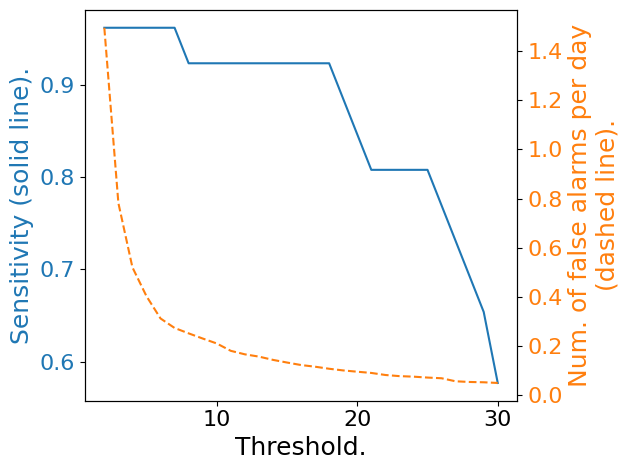

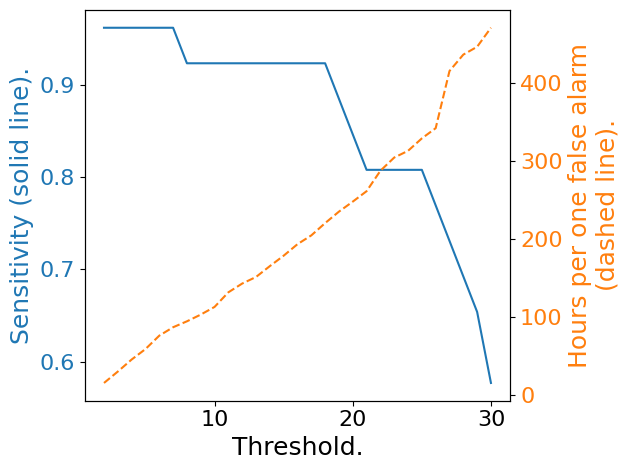

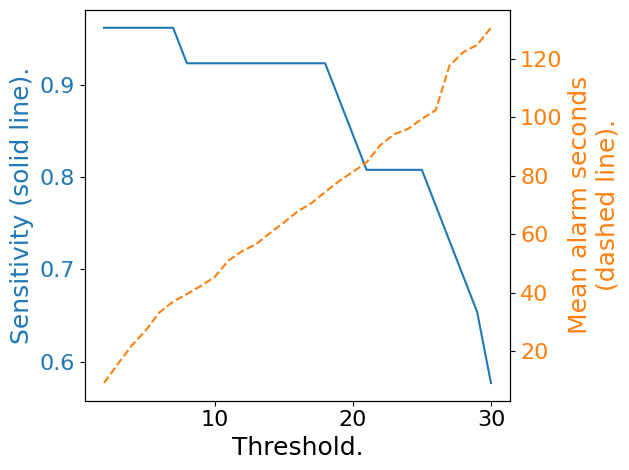

In [13]:
def plot_metrics(x, y1, y2, x_label, y1_label, y2_label, start_threshold, end_threshold, save_title):
    fontsize = 18
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel(x_label, fontsize=fontsize)
    ax1.tick_params(axis='x', labelsize=fontsize-2) 
    ax1.set_ylabel(y1_label, color=color, fontsize=fontsize)
    ax1.plot(x[start_threshold:end_threshold], y1[start_threshold:end_threshold], color=color, label=y1_label)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=fontsize-2)
    ax2 = ax1.twinx()
    color = 'tab:orange'
    ax2.set_ylabel(y2_label, color=color, fontsize=fontsize)
    ax2.plot(x[start_threshold:end_threshold], y2[start_threshold:end_threshold], color=color, label=y2_label, linestyle='dashed')
    ax2.tick_params(axis='y', labelcolor=color, labelsize=fontsize-2)
    fig.tight_layout()
    plt.savefig(save_title, dpi = 400, bbox_inches="tight")
    plt.show()
    plt.close()

start_threshold = 1
end_threshold = 30
plot_metrics(thresholds, sensitivity_list, false_alarm_rate_list,
             'Threshold.', 'Sensitivity (solid line).', 'Num. of false alarms per day\n(dashed line).',
             start_threshold, end_threshold, 'sensitivity-far.png')

plot_metrics(thresholds, sensitivity_list, hours_per_false_alarm_list,
             'Threshold.', 'Sensitivity (solid line).', 'Hours per one false alarm\n(dashed line).',
             start_threshold, end_threshold, 'sensitivity-hpfa.png')

plot_metrics(thresholds, sensitivity_list, mean_alarm_length_list,
             'Threshold.', 'Sensitivity (solid line).', 'Mean alarm seconds\n(dashed line).',
             start_threshold, end_threshold, 'sensitivity-mal.png')

# HMM

In [2]:
_type = "raw"
data_folder_name = "fall_test_2"
path = layout_database_path / "test_layout" / data_folder_name
train_SD = utils.pickle_load(path / "experiment", f"SD_mat_{_type}_1")
train_AL = utils.pickle_load(path / "experiment", f"AL_mat_{_type}_1")
train_SD_names = utils.pickle_load(path / "experiment", "SD_names")
train_AL_names = utils.pickle_load(path / "experiment", "AL_names")

# extract motion sensor data
train_SD_model = utils.pickle_load(path, "SD_model")
motion_sensor_indexes = []
for i, s_i in enumerate(train_SD_names):
    if train_SD_model[s_i].type_name in ['PIR', 'pressure', 'door'] and (i != 6):
        motion_sensor_indexes.append(i)
train_SD = train_SD[:, motion_sensor_indexes]
print(f"train_SD.shape: {train_SD.shape}")

# extract fall labels
anomaly_index = 4
train_AL = train_AL[:, anomaly_index]
print(f"train_AL_names[{anomaly_index}] = {train_AL_names[anomaly_index]}")
print(f"train_AL.shape: {train_AL.shape}")
print(f"np.sum(train_AL): {np.sum(train_AL)}")
train_fall_indices = analysis.find_true_regions_in_ndarray(train_AL)
print(f"train_fall_indices: {train_fall_indices}")

# learn HMM whose hidden states are two mode (normal and anomaly) 
hmm = analysis.HMM4binary_sensors()
hmm.use_log_prob = True
hmm.fit_with_true_hidden_states(train_SD, train_AL)
utils.pickle_dump(path / "experiment", f"hmm_fw", hmm)

train_SD.shape: (2592000, 36)
train_AL_names[4] = fall while walking
train_AL.shape: (2592000,)
np.sum(train_AL): 6138
train_fall_indices: [(32564, 32595), (38181, 38223), (75291, 75326), (142607, 142642), (143203, 143243), (153764, 153795), (159366, 159391), (165133, 165162), (166672, 166704), (198997, 199026), (229634, 229663), (231253, 231277), (234432, 234473), (235774, 235802), (239240, 239276), (241586, 241615), (242291, 242324), (244767, 244810), (248365, 248405), (249713, 249745), (282128, 282161), (284779, 284792), (287289, 287326), (298041, 298072), (304154, 304189), (313695, 313717), (337489, 337521), (366063, 366099), (370677, 370704), (373856, 373889), (395280, 395306), (405215, 405247), (416020, 416051), (418524, 418551), (423054, 423086), (454803, 454831), (457322, 457348), (457761, 457781), (463103, 463135), (479922, 479949), (486021, 486057), (486608, 486644), (488543, 488563), (490274, 490310), (494108, 494140), (504585, 504611), (554975, 555007), (566755, 566791), (5

c:\Users\tanakai\Documents\git\Simulator\src\analysis.py:1343: RuntimeWarning: divide by zero encountered in log
  np.log((s == i) @ seq[:, j]) - np.log(counts[i]),


In [2]:
# HMM with multivariate binary outputs
from sklearn.metrics import classification_report, confusion_matrix

_type = "raw"
start = 6 * 360 * 24 * 60 * 60
end = 9 * 360 * 24 * 60 * 60
# test HMM
data_folder_name = "test_data_5"
path = layout_database_path / "test_layout" / data_folder_name
test_SD = utils.pickle_load(path / "experiment", f"SD_mat_{_type}_1")
# test_AL = utils.pickle_load(path / "experiment", f"AL_mat_{_type}_1")
test_SD_names = utils.pickle_load(path / "experiment", "SD_names")
# test_AL_names = utils.pickle_load(path / "experiment", "AL_names")

# extract motion sensor data
test_SD_model = utils.pickle_load(path, "SD_model")
motion_sensor_indexes = []
for i, s_i in enumerate(test_SD_names):
    if test_SD_model[s_i].type_name in ['PIR', 'pressure', 'door'] and (i != 6):
        motion_sensor_indexes.append(i)
test_SD = test_SD[:, motion_sensor_indexes][start:end]
print(f"test_SD.shape: {test_SD.shape}")

# extract fall labels
anomaly_index = 4
# test_AL = test_AL[:, anomaly_index][start:end]
# print(f"test_AL_names[{anomaly_index}] = {test_AL_names[anomaly_index]}")
# print(f"test_AL.shape: {test_AL.shape}")
# print(f"np.sum(test_AL): {np.sum(test_AL)}")
# test_fall_indices = analysis.find_true_regions_in_ndarray(test_AL)
# print(f"test_fall_indices: {test_fall_indices}")

hmm = utils.pickle_load(layout_database_path / "test_layout" / "fall_test_2" / "experiment", "hmm_fw")
(y_pred, prob) = hmm.predict_states(test_SD)

# print(hmm.C)
# print(hmm.A)
# print(hmm.P)

# y_true = test_AL
# print("Confusion matrix:")
# print(confusion_matrix(y_true, y_pred))
# print("Classification report")
# print(classification_report(y_true, y_pred))

utils.pickle_dump(path / "experiment", f"y_pred_HMM_long_3_3", y_pred)

test_SD.shape: (93312000, 36)
Recursion prediction in HMM. 93300000 / 93312000.


In [2]:
data_folder_name = "test_data_5"
path = layout_database_path / "test_layout" / data_folder_name
y_1_3 = utils.pickle_load(path / "experiment", f"y_pred_HMM_long_1_3")
y_2_3 = utils.pickle_load(path / "experiment", f"y_pred_HMM_long_2_3")
y_3_3 = utils.pickle_load(path / "experiment", f"y_pred_HMM_long_3_3")
y_pred_HMM_long = np.concatenate((y_1_3, y_2_3, y_3_3))
utils.pickle_dump(path / "experiment", f"y_pred_HMM_long", y_pred_HMM_long)